In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
from scipy.stats import cauchy
import random

# Simulation

(array([-17.5, -17. , -16.5, -16. , -15.5, -15. , -14.5, -14. , -13.5,
        -13. , -12.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


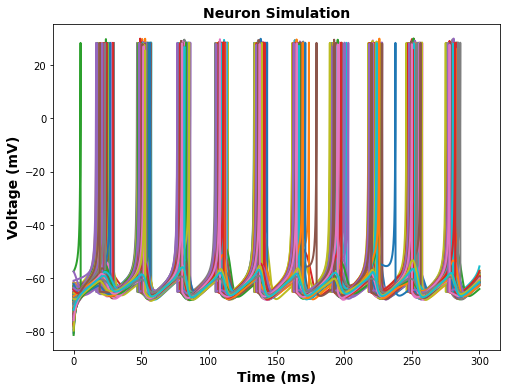

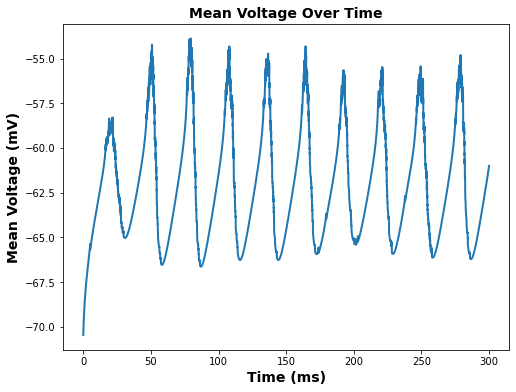

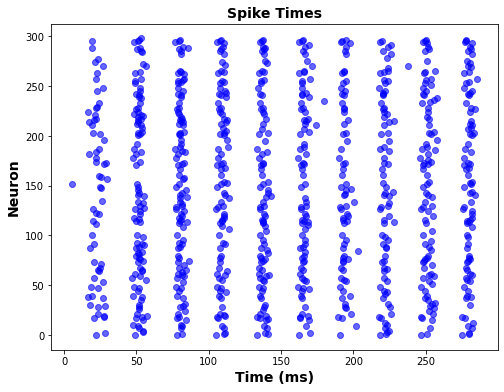

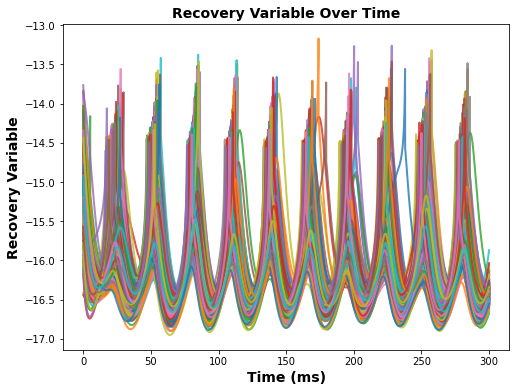

In [2]:
# Sparsely Connected
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033) #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('NeuronModel.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('MeanVoltage.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('SpikeTimes.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('RecoveryVariable.png')

(array([-32.5, -30. , -27.5, -25. , -22.5, -20. , -17.5, -15. , -12.5,
        -10. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

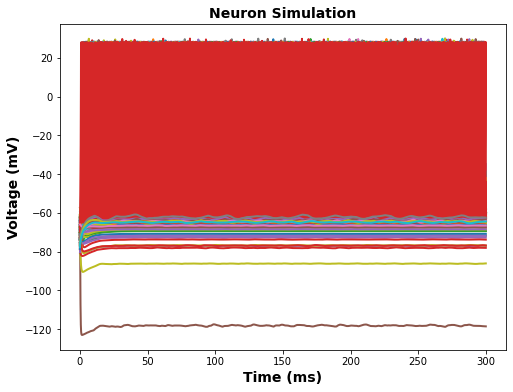

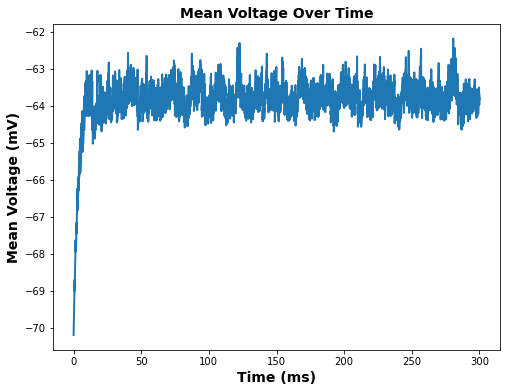

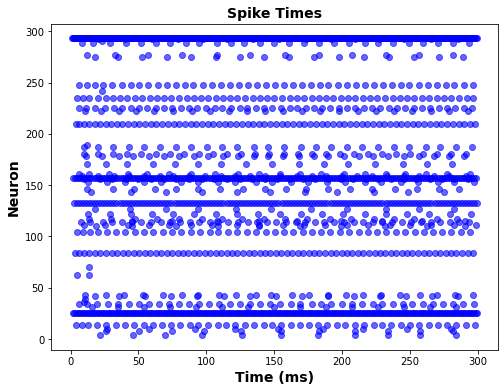

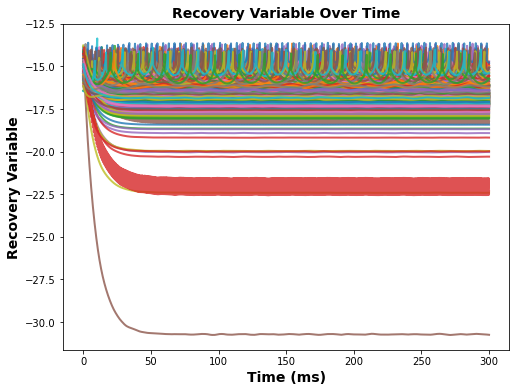

In [64]:
# Changing J from a normal distribution to a Lorentzian one
# Sparsely Connected
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

#J = np.random.normal(0, 0.1, size=(N))

# Parameters for Lorentzian (Cauchy) distribution
x0 = 0      # Location parameter (similar to mean)
gamma = 0.372  # Scale parameter (similar to standard deviation for normal)

# # Generate J from a Lorentzian (Cauchy) distribution
# J = np.random.standard_cauchy(size=N)
J = 1.48*cauchy.rvs(loc=x0, scale=gamma, size=N)


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033) #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('NeuronModel.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('MeanVoltage.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('SpikeTimes.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('RecoveryVariable.png')

In [4]:
# Compute the average values for u, v, and J over the whole 300-neuron system

# Average membrane potential (v) over all neurons and time steps
average_v = np.mean(y_all[:N, :])

# Average recovery variable (u) over all neurons and time steps
average_u = np.mean(y_all[N:2*N, :])

# Average external input current (J) over all neurons
average_J = np.mean(J)

p_mean = np.mean(y_all[3*N:4*N, :])



# Display results
average_v, average_u, average_J, p_mean

(-62.20309106944876,
 -16.2138477080415,
 0.0050802433530703186,
 0.0807359308718857)

In [5]:
avg_v_init = np.mean(v_init)
avg_u_init = np.mean(u_init)
avg_s_init = np.mean(s_init)
avg_p_init = np.mean(p_init)
avg_J = np.mean(J)

# Print the results
print(f"Average initial membrane potential (v): {avg_v_init} ")
print(f"Average initial recovery variable (u): {avg_u_init}")
print(f"Average initial synaptic state (s): {avg_s_init}")
print(f"Average initial auxiliary variable (p): {avg_p_init}")
print(f"Avergae Noise (J): {avg_J}")

Average initial membrane potential (v): -61.0055232349457 mV
Average initial recovery variable (u): -16.40836116140828
Average initial synaptic state (s): 0.008643104458891883
Average initial auxiliary variable (p): 0.0014034857041942254


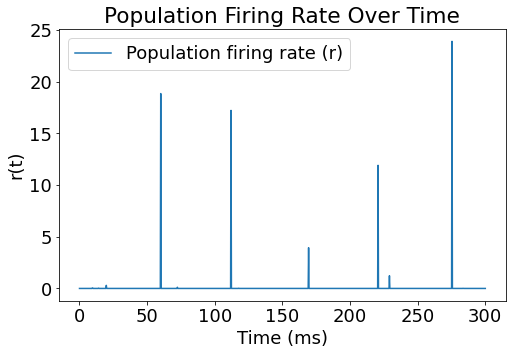

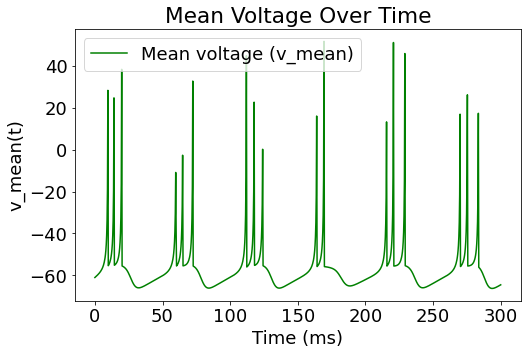

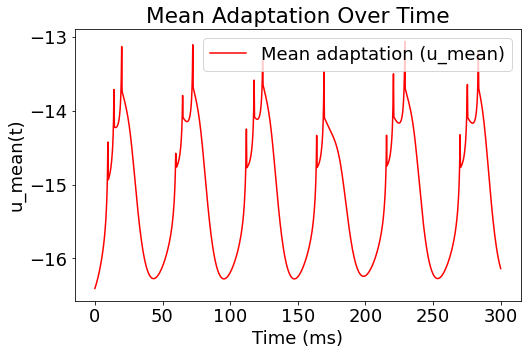

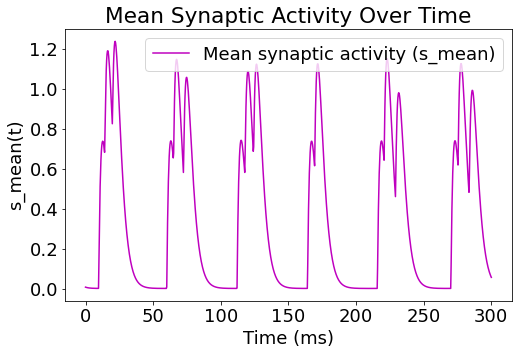

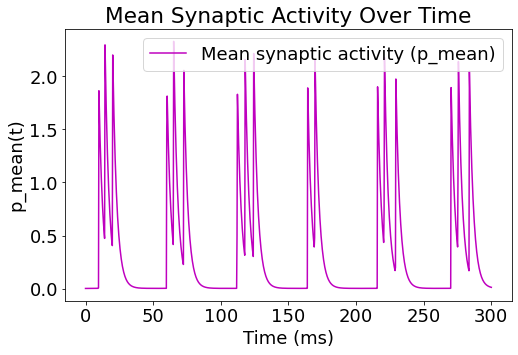

In [31]:
#  dsdt = -s / tauS + p / tauS
#  dpdt = -p / tauS

# Define mean-field equations for the Izhikevich resonator network
def mean_field_model(t, y, params):
    r, v_mean, u_mean, s_mean, p_mean = y  # Unpack state variables

    # Unpack parameters
    Delta_J, alpha, g_syn, E_syn, I_ext, tau_s, a, b, d, p_jump = params

    # Mean-field equations
    dr_dt = (Delta_J / np.pi) + 2 * r * v_mean - (alpha + g_syn * s_mean) * r
    dv_mean_dt = 0.04*v_mean**2 + 5 * v_mean  - u_mean + 140 + I_ext - (v_mean - E_syn) * g_syn * s_mean - np.pi**2 *r**2
    du_mean_dt = a * (b * v_mean - u_mean) + d * r
    ds_mean_dt = -s_mean / tau_s + p_mean / tau_s
    dp_mean_dt = -p_mean / tau_s + p_jump * r
    return [dr_dt, dv_mean_dt, du_mean_dt, ds_mean_dt, dp_mean_dt]

# Define parameters based on provided values
params = [
    0.1,    # Delta_J: Spread of external input current (J variance)
    5,     # alpha: Excitability parameter
    0.0039596666666666663,    # g_syn: Synaptic coupling strength
    -70.0,   # E_syn: Synaptic reversal potential
    0.33,    # I_ext: External drive
    3.043,   # tau_s: Synaptic decay time
    0.1,     # a: Recovery variable time constant
    0.26,    # b: Recovery sensitivity to voltage
    -1.0,    # d: After-spike adaptation jump
    2.718    # p_jump: Synaptic activation jump (x0)
]

# Initial conditions
# y0 = [r_init, v_init_avg, u_init_avg, s_init_avg, p_init_avg]
y0 = [0, -61.0055232349457, -16.40836116140828, 0.008643104458891883, 0.0014034857041942254]  

# Time span for simulation
t_span = (0, 300)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the system
sol = solve_ivp(mean_field_model, t_span, y0, args=(params,), t_eval=t_eval, method='RK45')

# Extract solutions
t_vals = sol.t
r_vals, v_mean_vals, u_mean_vals, s_mean_vals, p_mean_vals= sol.y

# Plot Population firing rate (r)
plt.figure(figsize=(8, 5))
plt.plot(t_vals, r_vals, label="Population firing rate (r)")
plt.xlabel("Time (ms)")
plt.ylabel("r(t)")
plt.title("Population Firing Rate Over Time")
plt.legend()
plt.show()

# Plot Mean voltage (v_mean)
plt.figure(figsize=(8, 5))
plt.plot(t_vals, v_mean_vals, label="Mean voltage (v_mean)", color='g')
plt.xlabel("Time (ms)")
plt.ylabel("v_mean(t)")
plt.title("Mean Voltage Over Time")
plt.legend()
plt.show()

# Plot Mean adaptation (u_mean)
plt.figure(figsize=(8, 5))
plt.plot(t_vals, u_mean_vals, label="Mean adaptation (u_mean)", color='r')
plt.xlabel("Time (ms)")
plt.ylabel("u_mean(t)")
plt.title("Mean Adaptation Over Time")
plt.legend()
plt.show()

# Plot Mean synaptic activity (s_mean)
plt.figure(figsize=(8, 5))
plt.plot(t_vals, s_mean_vals, label="Mean synaptic activity (s_mean)", color='m')
plt.xlabel("Time (ms)")
plt.ylabel("s_mean(t)")
plt.title("Mean Synaptic Activity Over Time")
plt.legend()
plt.show()

# Plot Mean synaptic activity (s_mean)
plt.figure(figsize=(8, 5))
plt.plot(t_vals, p_mean_vals, label="Mean synaptic activity (p_mean)", color='m')
plt.xlabel("Time (ms)")
plt.ylabel("p_mean(t)")
plt.title("Mean Synaptic Activity Over Time")
plt.legend()
plt.show()

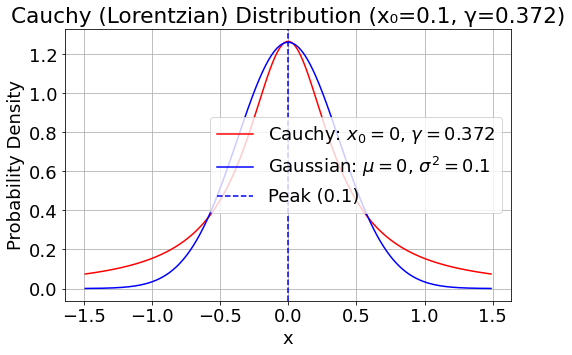

In [63]:
# Parameters
mu = 0  # Mean
sigma = np.sqrt(0.1)  # Standard deviation (since variance = 0.1)

# Generate x values
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)

# Compute Gaussian PDF
gaussian_pdf = norm.pdf(x, loc=mu, scale=sigma)

# Parameters
x0 = 0    # Location parameter (similar to mean)
gamma = 0.372  # Scale parameter (HWHM chosen to approximate std of 0.316)

# Generate x values
x = np.linspace(x0 - 4*gamma, x0 + 4*gamma, 1000)

# Compute Cauchy PDF
cauchy_pdf = 1.48*cauchy.pdf(x, loc=x0, scale=gamma)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, cauchy_pdf, label=f'Cauchy: $x_0={x0}$, $\\gamma={gamma}$', color='r')
plt.plot(x, gaussian_pdf, label=f'Gaussian: $\mu={mu}$, $\sigma^2=0.1$', color='b')
plt.axvline(x0, color='b', linestyle='dashed', label='Peak (0.1)')
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("Cauchy (Lorentzian) Distribution (x₀=0.1, γ=0.372)")
plt.legend()
plt.grid()
plt.show()
